In [1]:
import numpy as np
from scipy.optimize import minimize
from cvxopt import matrix, solvers
import os
import sys

In [2]:
#Prereq Stuff
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt


def linearKernel(X1, X2):
    return X1 @ X2.T


def polyKernel(X1, X2, degree):
    return (X1 @ X2.T + 1) ** degree


def gaussKernel(X1, X2, width):
    distances = cdist(X1, X2, 'sqeuclidean')
    return np.exp(- distances / (2*(width**2)))


def generateData(n, gen_model):

    # Controlling the random seed will give you the same 
    # random numbers every time you generate the data. 
    # The seed controls the internal random number generator (RNG).
    # Different seeds produce different random numbers. 
    # This can be handy if you want reproducible results for debugging.
    # For example, if your code *sometimes* gives you an error, try
    # to find a seed number (0 or others) that produces the error. Then you can
    # debug your code step-by-step because every time you get the same data.

    # np.random.seed(0)  # control randomness when debugging

    if gen_model == 1 or gen_model == 2:
        # Gen 1 & 2
        d = 2
        w_true = np.ones([d, 1])

        X = np.random.randn(n, d)

        if gen_model == 1:
            y = np.sign(X @ w_true)  # generative model 1
        else:
            y = np.sign((X ** 2) @ w_true - 1)  # generative model 2

    elif gen_model == 3:
        # Gen 3
        X, y = generateMoons(n)

    else:
        raise ValueError("Unknown generative model")

    return X, y


def generateMoons(n, noise=0.1):
    n_samples_out = n // 2
    n_samples_in = n - n_samples_out
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5

    X = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), 
         np.append(outer_circ_y, inner_circ_y)]
    ).T
    X += np.random.randn(*X.shape) * noise

    y = np.hstack(
        [-np.ones(n_samples_out, dtype=np.intp), 
         np.ones(n_samples_in, dtype=np.intp)]
    )[:, None]
    return X, y


def plotPoints(X, y):
    # plot the data points from two classes
    X0 = X[y.flatten() >= 0]
    X1 = X[y.flatten() < 0]

    plt.scatter(X0[:, 0], X0[:, 1], marker='x', label='class -1')
    plt.scatter(X1[:, 0], X1[:, 1], marker='o', label='class +1')
    return


def getRange(X):
    x_min = np.amin(X[:, 0]) - 0.1
    x_max = np.amax(X[:, 0]) + 0.1
    y_min = np.amin(X[:, 1]) - 0.1
    y_max = np.amax(X[:, 1]) + 0.1
    return x_min, x_max, y_min, y_max


def plotModel(X, y, w, w0, classify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = classify(np.c_[xx.ravel(), yy.ravel()], w, w0)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()
    return


def plotAdjModel(X, y, a, a0, kernel_func, adjClassify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = adjClassify(np.c_[xx.ravel(), yy.ravel()], a, a0, X, kernel_func)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()
    return


def plotDualModel(X, y, a, b, lamb, kernel_func, dualClassify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = dualClassify(np.c_[xx.ravel(), yy.ravel()], a, b, X, y, 
                     lamb, kernel_func)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()

    return


def plotDigit(x):
    img = x.reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.show()
    return



In [11]:
#temp

#q2c
def adjClassify(Xtest, a, a0, X, kernel_func):
    return np.sign( (kernel_func(Xtest,X)@ a + a0)  )

    

Optimized weights: [-5.73679820e-03 -1.86601675e-03 -2.70800773e-03 -2.03198463e-03
 -2.32095461e-03 -1.01698381e-03 -6.17726176e-03 -2.90076102e-03
 -1.71046408e-03 -6.26766864e-03 -1.40289792e-03 -4.35070316e-04
 -1.37915785e-03 -6.89779550e-04 -3.60714931e-03 -2.49218144e-03
  2.83819387e-03  1.42580752e-03 -1.01776545e-03  1.64542858e-03
  7.12650412e-03  4.01207282e-03  1.80400855e-03 -2.13114091e-04
  4.29969060e-03  5.52073591e-04  3.52154132e-03 -1.71582120e-03
  4.35269585e-03  3.88929790e-03  1.86937510e-03  5.30696110e-03
  2.18467629e-03 -2.67200752e-03 -1.38571939e-03 -3.15192354e-04
  4.68392646e-04  1.88006468e-03  2.96278995e-03 -9.32609264e-04
 -4.02701997e-04 -1.32459758e-04  1.98945559e-03 -2.13960681e-03
 -4.89418239e-03  2.86210686e-03 -8.55188298e-04  1.73165170e-03
 -3.93874442e-03 -4.12319209e-03 -2.62473746e-03  3.35915288e-04
  1.01282562e-03 -1.98989701e-04 -1.85194217e-03 -2.60254429e-03
 -2.80415920e-03  6.41644285e-05 -5.39169960e-03 -1.44977080e-03
 -1.13

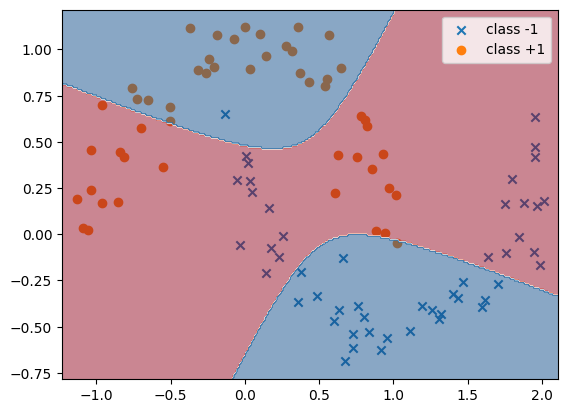

In [81]:
#q2a

def objective_function(params, y, lamb, K):
    n = len(y)
    
    alpha = params[:n]
    alpha0 = params[n]
    
    linear_combination = (K @ alpha) + alpha0
    loss = np.sum(np.logaddexp(0, -y * linear_combination))
    
    regularization = (lamb / 2) * alpha.T @ K @ alpha
    return loss + regularization


def adjBinDev(X, y, lamb, kernel_func):
    n, d = X.shape
    K = kernel_func(X, X)
    initial_params = np.ones(n + 1)
    
    result = minimize(objective_function, initial_params, args=(y, lamb, K))
    
    a = result.x[:-1]
    a0 = result.x[-1]

    return a, a0



#  usage
X,y = generateData(100,3)
lamb = 1
kernel_func = lambda X1, X2 : gaussKernel(X1,X2,8)

a, a0 = adjBinDev(X, y, lamb,kernel_func)

print("Optimized weights:", a)
print("Optimized bias:", a0) 

plotAdjModel(X,y,a,a0,kernel_func,adjClassify)

     pcost       dcost       gap    pres   dres
 0: -8.3305e+01  1.6945e+02  8e+02  4e+00  4e+05
 1:  5.7793e+01 -3.8065e+01  1e+02  4e-01  5e+04
 2:  3.1071e+01 -1.6596e+01  6e+01  1e-01  2e+04
 3:  1.6410e+01 -6.7875e+00  3e+01  6e-02  7e+03
 4:  9.8009e+00 -3.6247e+00  2e+01  2e-02  3e+03
 5:  5.0118e+00 -8.7105e-01  6e+00  8e-03  9e+02
 6:  3.5991e+00 -1.9529e-01  4e+00  3e-03  4e+02
 7:  2.3088e+00  5.5983e-01  2e+00  1e-03  2e+02
 8:  2.1468e+00  4.5230e-01  2e+00  1e-03  1e+02
 9:  1.5933e+00  6.6377e-01  1e+00  5e-04  6e+01
10:  1.1453e+00  9.0505e-01  2e-01  4e-14  5e-12
11:  1.0156e+00  9.8982e-01  3e-02  4e-14  1e-11
12:  1.0007e+00  1.0004e+00  3e-04  6e-14  2e-11
Terminated (singular KKT matrix).
Optimized weights: [-2.55955943e-03 -2.36986244e-05  6.62009680e-04 -2.97226741e-03
 -2.80506086e-04 -1.27596443e-02  5.12303264e-03 -1.78983864e-02
  1.25212636e-02  1.08622748e-02 -8.43646034e-04 -1.65941226e-03
 -2.12469333e-03 -1.85754821e-02  2.50060934e-03  7.34458553e-03
 -

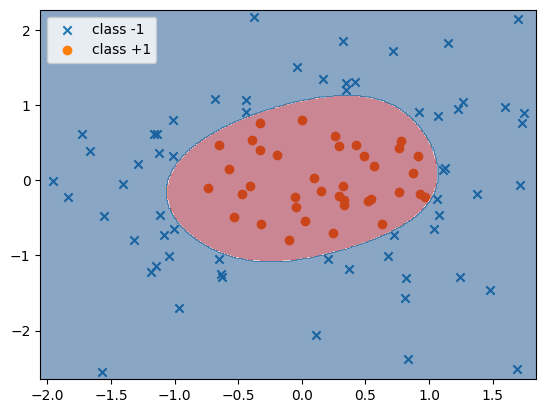

In [80]:
#q2b

def adjHinge(X, y, lamb, kernel_func, stabilizer=1e-5):
    n, d = X.shape
    #print("n = ", n)
    #print("d = ", d)
    K = kernel_func(X, X) 

    y = np.array(y, dtype=np.double)
    #print("Shape of y : ", y.shape)


    P = np.zeros((2*n + 1, 2*n+1)) 
    P[:n, :n] = lamb * K  # Kernel matrix for alpha terms
    P = matrix(P + stabilizer * np.eye(2*n+1))  # Stabilization

    q = matrix(np.hstack([np.zeros(n + 1),  np.ones(n)]))
    
    # Create G matrix
    # G1: For the non-negativity constraints of the slack variables 
    G11 = np.zeros([n,n]) #for 1, its nxd
    G12 = np.zeros([n,1])
    G13 = -np.eye(n)
    G1 = np.hstack([G11,G12,G13])
    
    # G2: For the hinge constraints
    G21 = -y * K
    G22 = -y * np.ones([n,1])
    G23 = -np.eye(n)
    G2 = np.hstack([G21,G22,G23])

    G = np.vstack([G1, G2])  # Stack G1 and G2 to form the full G matrix

    # Create the h vector
    h = np.concatenate([np.zeros(n), -np.ones(n)]) 

    # Convert 
    P = matrix(P)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)

    solution = solvers.qp(P, q, G, h)

    # Extract solutions for α and α_0
    alphas = np.array(solution['x'][:n])
    alpha0 = np.array(solution['x'][n])

    return alphas, alpha0

# Example usage
X,y = generateData(100,2)
lamb = 1# Regularization parameter

kernel_func = lambda X1, X2 : polyKernel(X1,X2,6)

a, a0 = adjHinge(X, y, lamb,kernel_func)

print("Optimized weights:", a.flatten())
print("Optimized bias:", a0)

plotAdjModel(X,y,a,a0,kernel_func,adjClassify)

In [10]:
#q2c
def adjClassify(Xtest, a, a0, X, kernel_func):
    yhat = np.sign( (kernel_func(Xtest,X)@ a + a0)  )




In [ ]:
#q2d

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def predict(X, alphas, alpha0, kernel, X_support):
    K = kernel(X_support, X)
    predictions = K.T.dot(alphas) + alpha0
    return np.sign(predictions)

def sunExperimentsKernel():
    n_runs = 10 
    n_train = 100
    n_test = 1000
    lamb = 0.001
    kernel_list = [linearKernel,
                   lambda X1, X2: polyKernel(X1, X2, 2),
                   lambda X1, X2: polyKernel(X1, X2, 3),
                   lambda X1, X2: gaussKernel(X1, X2, 1.0),
                   lambda X1, X2: gaussKernel(X1, X2, 0.5)]
    
    gen_model_list = [1, 2, 3]
    
    train_acc_bindev = np.zeros([len(kernel_list), len(gen_model_list), n_runs])
    test_acc_bindev = np.zeros([len(kernel_list), len(gen_model_list), n_runs])
    train_acc_hinge = np.zeros([len(kernel_list), len(gen_model_list), n_runs])
    test_acc_hinge = np.zeros([len(kernel_list), len(gen_model_list), n_runs])
    
    for r in range(n_runs):
        for i, kernel in enumerate(kernel_list):
            for j, gen_model in enumerate(gen_model_list):
                Xtrain, ytrain = generateData(n=n_train, gen_model=gen_model)
                Xtest, ytest = generateData(n=n_test, gen_model=gen_model)
                
                # BinDev model
                a, a0 = adjBinDev(Xtrain, ytrain, lamb, kernel)
                train_pred_bindev = predict(Xtrain, a, a0, kernel, Xtrain)
                test_pred_bindev = predict(Xtest, a, a0, kernel, Xtrain)
                train_acc_bindev[i, j, r] = compute_accuracy(ytrain, train_pred_bindev)
                test_acc_bindev[i, j, r] = compute_accuracy(ytest, test_pred_bindev)
                
                # Hinge model
                
                a, a0 = adjHinge(Xtrain, ytrain, lamb, kernel)
                train_pred_hinge = predict(Xtrain, a, a0, kernel, Xtrain)
                test_pred_hinge = predict(Xtest, a, a0, kernel, Xtrain)
                train_acc_hinge[i, j, r] = compute_accuracy(ytrain, train_pred_hinge)
                test_acc_hinge[i, j, r] = compute_accuracy(ytest, test_pred_hinge)
                

    # Compute average accuracies over runs
    avg_train_acc_bindev = np.mean(train_acc_bindev, axis=2)
    avg_test_acc_bindev = np.mean(test_acc_bindev, axis=2)
    avg_train_acc_hinge =  np.mean(train_acc_hinge, axis=2)
    avg_test_acc_hinge =  np.mean(test_acc_hinge, axis=2)
    
    # Return or print results
    return avg_train_acc_bindev, avg_test_acc_bindev, avg_train_acc_hinge, avg_test_acc_hinge

# Call function
avg_train_acc_bindev, avg_test_acc_bindev, avg_train_acc_hinge, avg_test_acc_hinge = sunExperimentsKernel()

# Print results
print("Average Train Accuracies - Binary Deviance:", avg_train_acc_bindev)
print("Average Test Accuracies - Binary Deviance:", avg_test_acc_bindev)
print("Average Train Accuracies - Hinge:", avg_train_acc_hinge)
print("Average Test Accuracies - Hinge:", avg_test_acc_hinge)


solvers.options['show_progress'] = False

     pcost       dcost       gap    pres   dres
 0: -6.2810e+01  2.6396e+02  1e+03  5e+00  2e+02
 1:  1.2320e+02 -1.0037e+02  3e+02  7e-01  3e+01
 2:  4.5038e+01 -2.0565e+01  8e+01  2e-01  8e+00
 3:  1.7507e+01 -7.9381e+00  3e+01  6e-02  3e+00
 4:  8.4160e+00 -2.1116e+00  1e+01  2e-02  1e+00
 5:  5.8372e+00 -1.5321e+00  8e+00  2e-02  7e-01
 6:  4.7231e+00 -8.1077e-01  6e+00  1e-02  5e-01
 7:  2.6754e+00 -1.1924e+00  4e+00  6e-03  3e-01
 8:  2.7077e+00 -1.1718e+00  4e+00  6e-03  3e-01
 9:  2.7414e+00 -1.1600e+00  4e+00  5e-03  2e-01
10:  2.3090e+00 -1.3137e+00  4e+00  4e-03  2e-01
11:  2.0951e+00 -1.5054e+00  4e+00  3e-03  1e-01
12:  1.6250e+00 -9.8052e-01  3e+00  1e-03  5e-02
13:  1.4974e+00 -5.8094e-01  2e+00  6e-04  3e-02
14:  5.6010e-01  4.4100e-02  5e-01  1e-04  7e-03
15:  2.8250e-01  2.5635e-01  3e-02  2e-14  6e-16
16:  2.6785e-01  2.6759e-01  3e-04  1e-14  8e-16
17:  2.6770e-01  2.6770e-01  3e-06  2e-14  6e-16
18:  2.6770e-01  2.6770e-01  3e-08  1e-14  2e-15
Optimal solution foun